In [3]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

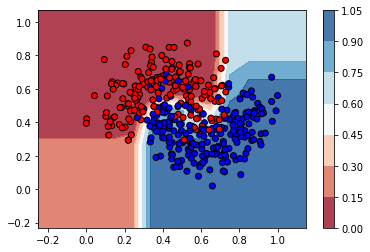

In [51]:
# Make dataset and train a random forest classifier

X, y = sklearn.datasets.make_moons(n_samples=2000, noise=0.35)
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

clf = RandomForestClassifier().fit(X_train, y_train)

h = 0.1
x_min, x_max = X_train[:, 0].min() - .25, X_train[:, 0].max() + .25
y_min, y_max = X_train[:, 1].min() - .25, X_train[:, 1].max() + .25
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict_proba(np.stack([xx.ravel(), yy.ravel()]).T)[:, 1]
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm, alpha=.8)
plt.colorbar()
# spectral clustering then * det(J)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')

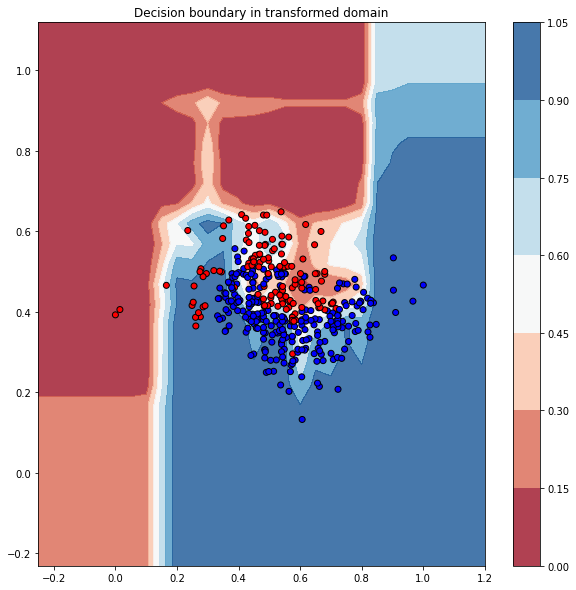

In [52]:
# Uniformise the data - and plot the decision boundaries in the uniform domain
from sklearn.preprocessing import QuantileTransformer

transformers = []
n_quantiles = np.arange(2, 300, 30)
for q in n_quantiles:
    transformer = QuantileTransformer(n_quantiles=q)
    transformer.fit(X_train)
    transformers.append(transformer)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
X_u_last = transformers[-1].transform(X_train)
u_min, u_max = X_u_last.min(axis=0), X_u_last.max(axis=0)
x_min, x_max = X_train[:, 0].min() - .25, X_train[:, 0].max() + .25
y_min, y_max = X_train[:, 1].min() - .25, X_train[:, 1].max() + .25
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
inv_data = transformers[-1].inverse_transform(np.stack([xx.ravel(), yy.ravel()]).T)
inv_data_real = transformers[-1].inverse_transform(X_train)
Z = clf.predict_proba(inv_data)[:, 1]
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm, alpha=.8)
plt.colorbar()
ax.set_title('Decision boundary in transformed domain')
plt.scatter(inv_data_real[:, 0], inv_data_real[:, 1], c=clf.predict(inv_data_real), cmap=cm_bright, edgecolors='k')

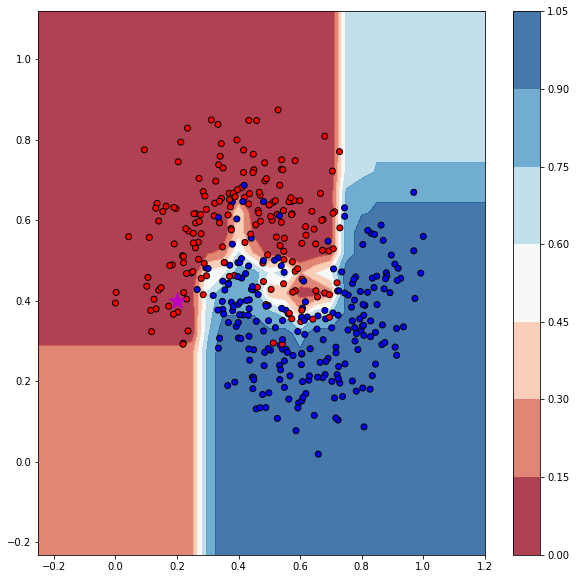

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
query_point = np.array([0.2, 0.4])
Z = clf.predict_proba(np.stack([xx.ravel(), yy.ravel()]).T)[:, 1]
c = ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm, alpha=.8)
plt.colorbar(c)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
ax.scatter(query_point[0], query_point[1], s=300, marker='*', c='m')

In [81]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import entropy
models = []
sampled_data = []
entropys = []
distances = []
n_samples=100
query_point = np.array([0.2, 0.4])
sigma=0.2

X_sample, _ = sklearn.datasets.make_moons(n_samples=20000, noise=0.3)
org_data = X_sample[np.where(
    np.logical_and(
        np.logical_and(X_sample[:,0]>=query_point[0]-sigma, X_sample[:,0]<=query_point[0]+sigma),
        np.logical_and(X_sample[:,1]>=query_point[1]-sigma, X_sample[:,1]<=query_point[1]+sigma)))]
org_data = np.random.permutation(org_data)[0:n_samples]

# Ground truth
ground_truth = Ridge()
prediction_probs = clf.predict(org_data)
ground_truth.fit(org_data, prediction_probs)
gt_var = np.hstack([ground_truth.coef_, ground_truth.intercept_])

for t in transformers:
    model = Ridge()
    ranges = t.transform(np.array([[query_point[0]-sigma, query_point[1]-sigma], [query_point[0]+sigma, query_point[1]+sigma]]))
    np.random.seed(42)
    data = np.random.uniform(low=[ranges[0][0], ranges[0][1]],
                             high=[ranges[1][0], ranges[1][1]],
                             size=(n_samples, 2))
    inv_data = t.inverse_transform(data)
    prediction_probs = clf.predict(inv_data)
    model.fit(inv_data, prediction_probs)
    models.append(model)
    entropys.append(entropy(org_data, inv_data))
    sampled_data.append(inv_data)
    distances.append(mean_squared_error(gt_var, np.hstack([model.coef_, model.intercept_])**2))

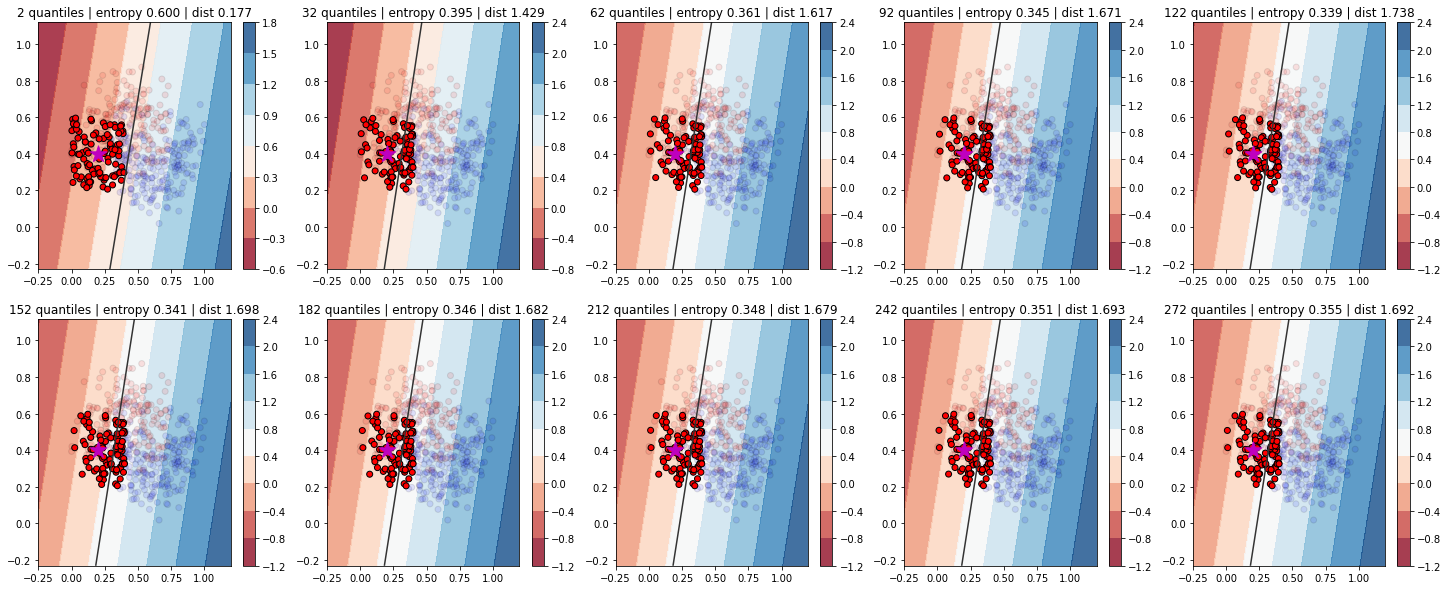

In [82]:
fig, axs = plt.subplots(2, int(len(transformers)/2), figsize=(int(len(transformers)/2)*5, 10))

for i, ax in enumerate(axs.flat):
    Z = models[i].predict(np.stack([xx.ravel(), yy.ravel()]).T)
    c = ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm, alpha=.8)
    plt.colorbar(c, ax=ax)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k', alpha=0.1)
    ax.scatter(sampled_data[i][:, 0], sampled_data[i][:, 1], c=np.zeros_like(sampled_data[i][:, 1])+5, cmap=cm_bright, edgecolors='k')
    ax.contour(xx, yy, Z.reshape(xx.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    ax.scatter(query_point[0], query_point[1], s=300, marker='*', c='m')
    ax.set_title('%d quantiles | entropy %.3f | dist %.3f'%(n_quantiles[i], np.sum(entropys[i]), distances[i]))

In [83]:
models = []
sampled_data = []
entropys = []
distances = []
query_point = np.array([0.4, 0.6])

X_sample, _ = sklearn.datasets.make_moons(n_samples=20000, noise=0.3)
org_data = X_sample[np.where(
    np.logical_and(
        np.logical_and(X_sample[:,0]>=query_point[0]-sigma, X_sample[:,0]<=query_point[0]+sigma),
        np.logical_and(X_sample[:,1]>=query_point[1]-sigma, X_sample[:,1]<=query_point[1]+sigma)))]
org_data = np.random.permutation(org_data)[0:n_samples]

# Ground truth
ground_truth = Ridge()
prediction_probs = clf.predict(org_data)
ground_truth.fit(org_data, prediction_probs)
gt_var = np.hstack([ground_truth.coef_, ground_truth.intercept_])

for t in transformers:
    model = Ridge()
    ranges = t.transform(np.array([[query_point[0]-sigma, query_point[1]-sigma], [query_point[0]+sigma, query_point[1]+sigma]]))
    np.random.seed(42)
    data = np.random.uniform(low=[ranges[0][0], ranges[0][1]],
                             high=[ranges[1][0], ranges[1][1]],
                             size=(n_samples, 2))
    inv_data = t.inverse_transform(data)
    prediction_probs = clf.predict(inv_data)
    model.fit(inv_data, prediction_probs)
    models.append(model)
    entropys.append(entropy(org_data, inv_data))
    sampled_data.append(inv_data)
    distances.append(mean_squared_error(gt_var, np.hstack([model.coef_, model.intercept_])**2))

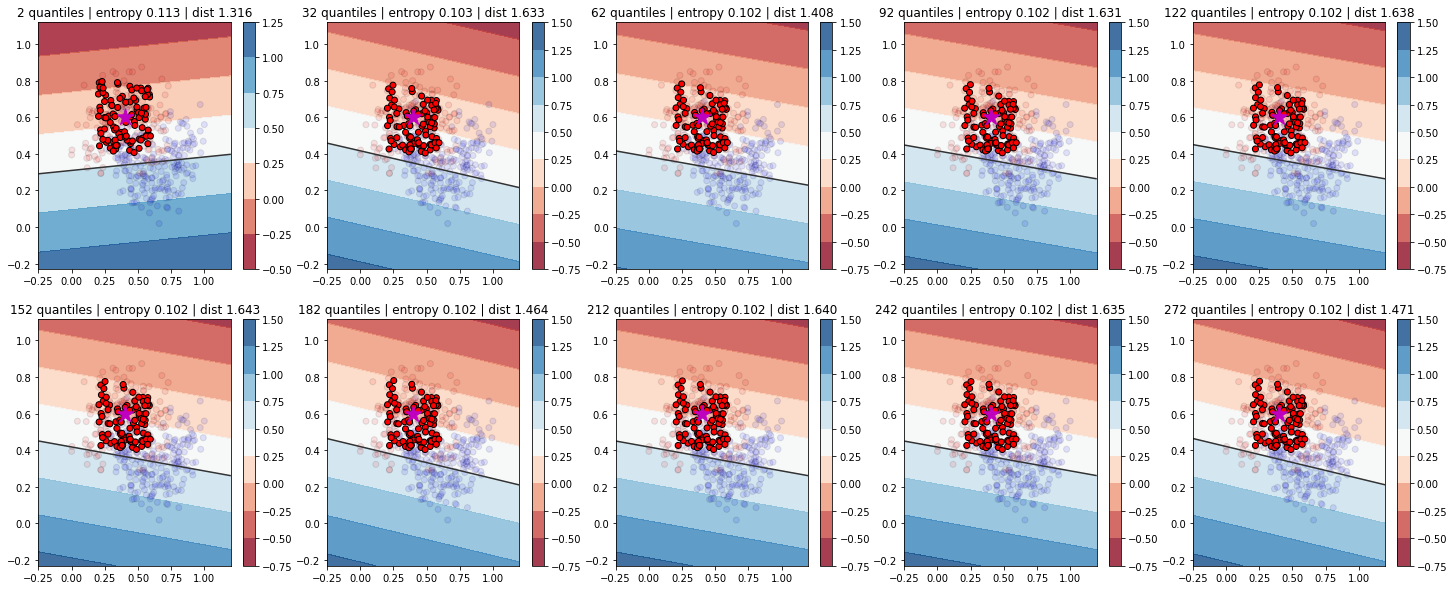

In [84]:
fig, axs = plt.subplots(2, int(len(transformers)/2), figsize=(int(len(transformers)/2)*5, 10))

for i, ax in enumerate(axs.flat):
    Z = models[i].predict(np.stack([xx.ravel(), yy.ravel()]).T)
    c = ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm, alpha=.8)
    plt.colorbar(c, ax=ax)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k', alpha=0.1)
    ax.scatter(sampled_data[i][:, 0], sampled_data[i][:, 1], c=np.zeros_like(sampled_data[i][:, 1])+5, cmap=cm_bright, edgecolors='k')
    ax.contour(xx, yy, Z.reshape(xx.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    ax.scatter(query_point[0], query_point[1], s=300, marker='*', c='m')
    ax.set_title('%d quantiles | entropy %.3f | dist %.3f'%(n_quantiles[i], np.sum(entropys[i]), distances[i]))

In [85]:
models = []
sampled_data = []
entropys = []
distances = []
query_point = np.array([0.6, 0.45])

X_sample, _ = sklearn.datasets.make_moons(n_samples=20000, noise=0.3)
org_data = X_sample[np.where(
    np.logical_and(
        np.logical_and(X_sample[:,0]>=query_point[0]-sigma, X_sample[:,0]<=query_point[0]+sigma),
        np.logical_and(X_sample[:,1]>=query_point[1]-sigma, X_sample[:,1]<=query_point[1]+sigma)))]
org_data = np.random.permutation(org_data)[0:n_samples]

# Ground truth
ground_truth = Ridge()
prediction_probs = clf.predict(org_data)
ground_truth.fit(org_data, prediction_probs)
gt_var = np.hstack([ground_truth.coef_, ground_truth.intercept_])

for t in transformers:
    model = Ridge()
    ranges = t.transform(np.array([[query_point[0]-sigma, query_point[1]-sigma], [query_point[0]+sigma, query_point[1]+sigma]]))
    np.random.seed(42)
    data = np.random.uniform(low=[ranges[0][0], ranges[0][1]],
                             high=[ranges[1][0], ranges[1][1]],
                             size=(n_samples, 2))
    inv_data = t.inverse_transform(data)
    prediction_probs = clf.predict(inv_data)
    model.fit(inv_data, prediction_probs)
    models.append(model)
    entropys.append(entropy(org_data, inv_data))
    sampled_data.append(inv_data)
    distances.append(mean_squared_error(gt_var, np.hstack([model.coef_, model.intercept_])**2))

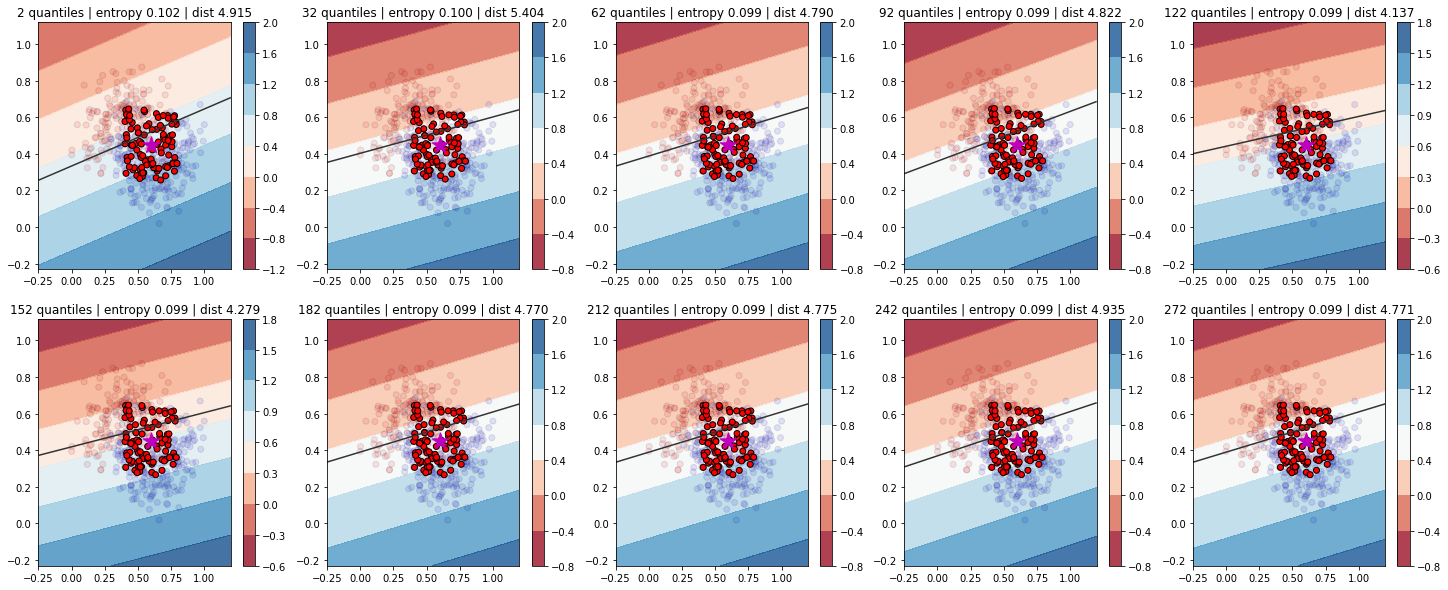

In [86]:
fig, axs = plt.subplots(2, int(len(transformers)/2), figsize=(int(len(transformers)/2)*5, 10))

for i, ax in enumerate(axs.flat):
    Z = models[i].predict(np.stack([xx.ravel(), yy.ravel()]).T)
    c = ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm, alpha=.8)
    plt.colorbar(c, ax=ax)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k', alpha=0.1)
    ax.scatter(sampled_data[i][:, 0], sampled_data[i][:, 1], c=np.zeros_like(sampled_data[i][:, 1])+5, cmap=cm_bright, edgecolors='k')
    ax.contour(xx, yy, Z.reshape(xx.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    ax.scatter(query_point[0], query_point[1], s=300, marker='*', c='m')
    ax.set_title('%d quantiles | entropy %.3f | dist %.3f'%(n_quantiles[i], np.sum(entropys[i]), distances[i]))

In [87]:
# sample according to distribution and measure distance to best possible surrogate (trained with local true distribution)
# fix random seed
# mixture of Gaussians
# use CLIP to generate?
# need to measure the difference for surrogates trained on transformed images and original dataset